In [ ]:
#Importing Libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
# STEP 1. Load datasets
# -----------------------------

# Replace these with your local file paths if needed
clicks_path = "clicks.dataset.2.xlsx"
volumes_path = "volumes.dataset.2.xlsx"
# Load clicks Excel (the file has non-standard layout)
clicks_df_raw = pd.read_excel(clicks_path, header=None)

# Extract clicks and exposures
clicks = clicks_df_raw.iloc[1, 1:].astype(int).values
exposures = clicks_df_raw.iloc[2, 1:].astype(int).values

# Load volumes (each row = one click, with columns ad and volume)
volumes_df = pd.read_excel(volumes_path)

In [ ]:
# Compute per-ad statistics for post-click volumes
grouped = (
    volumes_df.groupby('ad')['volume']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .rename(columns={'count': 'n', 'std': 'sd'})
)
grouped['var'] = grouped['sd'] ** 2

print("Per-campaign descriptive stats for post-click volumes:")
print(grouped, "\n")

Per-campaign descriptive stats for post-click volumes:
   ad   n       mean         sd         var
0   1  52  42.076923  10.032977  100.660633
1   2  38  57.289474  17.396657  302.643670
2   3  51  41.803922  13.891033  192.960784
3   4  45  47.888889  13.534841  183.191919
4   5  25  90.640000  30.686425  941.656667 



In [ ]:
# -----------------------------
# STEP 2. Bayesian simulations
# -----------------------------

n_draws = 100000
np.random.seed(123)  # Optional: for reproducibility

# --- 2.1 CTR posterior (Beta distribution) ---
alphas = clicks + 1
betas = exposures - clicks + 1

ctr_draws = np.vstack([
    stats.beta.rvs(a=alphas[i], b=betas[i], size=n_draws)
    for i in range(len(alphas))
]).T  # shape = (n_draws, n_campaigns)

# --- 2.2 Post-click volume posterior (Student-t distribution) ---
v_means = grouped['mean'].values
v_sds = grouped['sd'].values
v_ns = grouped['n'].values

v_draws = np.zeros_like(ctr_draws)
for i in range(len(v_ns)):
    df = int(v_ns[i] - 1)
    t_samples = stats.t.rvs(df=df, size=n_draws) if df > 0 else np.random.standard_t(1, size=n_draws)
    se = v_sds[i] / np.sqrt(v_ns[i]) if v_ns[i] > 0 else 1.0
    v_draws[:, i] = v_means[i] + t_samples * se

# --- 2.3 Expected Volume per Impression (EVI = c * v) ---
evi_draws = ctr_draws * v_draws

In [ ]:
# -----------------------------
# STEP 3. Compute posterior probabilities
# -----------------------------

# Identify which campaign wins in each draw
max_ctr = np.argmax(ctr_draws, axis=1)
max_v = np.argmax(v_draws, axis=1)
max_evi = np.argmax(evi_draws, axis=1)

# Compute posterior probabilities
prob_ctr_best = [(max_ctr == i).mean() for i in range(5)]
prob_v_best = [(max_v == i).mean() for i in range(5)]
prob_evi_best = [(max_evi == i).mean() for i in range(5)]

# Posterior means
post_mean_ctr = ctr_draws.mean(axis=0)
post_mean_v = v_draws.mean(axis=0)
post_mean_evi = evi_draws.mean(axis=0)

# Combine into summary DataFrame
results = pd.DataFrame({
    'campaign': [1, 2, 3, 4, 5],
    'clicks': clicks,
    'exposures': exposures,
    'obs_ctr': clicks / exposures,
    'sample_mean_v': v_means,
    'sample_sd_v': v_sds,
})

print("Posterior Summary Table: CTR")
print(results, "\n")


# Combine into summary DataFrame
results = pd.DataFrame({
    'campaign': [1, 2, 3, 4, 5],
    'obs_ctr_times_meanvol': (clicks / exposures) * v_means,
    'post_mean_ctr': post_mean_ctr,
    'prob_ctr_best': prob_ctr_best,
    'post_mean_v': post_mean_v,
})

print("Posterior Summary Table:Post Click Transaction Volume")
print(results, "\n")

results = pd.DataFrame({
    'campaign': [1, 2, 3, 4, 5],
    'post_mean_evi': post_mean_evi,
    'prob_evi_best': prob_evi_best
})

print("Posterior Summary Table: EVI")
print(results, "\n")


Posterior Summary Table: CTR
   campaign  clicks  exposures  obs_ctr  sample_mean_v  sample_sd_v
0         1      52       1000    0.052      42.076923    10.032977
1         2      38       1000    0.038      57.289474    17.396657
2         3      51       1000    0.051      41.803922    13.891033
3         4      45       1000    0.045      47.888889    13.534841
4         5      25       1000    0.025      90.640000    30.686425 

Posterior Summary Table:Post Click Transaction Volume
   campaign  obs_ctr_times_meanvol  post_mean_ctr  prob_ctr_best  post_mean_v
0         1                  2.188       0.052907        0.46982    42.072312
1         2                  2.177       0.038920        0.01666    57.294062
2         3                  2.132       0.051880        0.39554    41.799795
3         4                  2.155       0.045916        0.11793    47.889701
4         5                  2.266       0.025946        0.00005    90.629483 

Posterior Summary Table: EVI
   campa

EVI is highest for Ad campagin 5 which is 0.34171

In [ ]:
# -----------------------------
# STEP 4. Save results to CSV
# -----------------------------
output_csv = "display_ad_bayesian_results.csv"
results.to_csv(output_csv, index=False)
print(f"Results saved as: {output_csv}\n")

Results saved as: display_ad_bayesian_results.csv



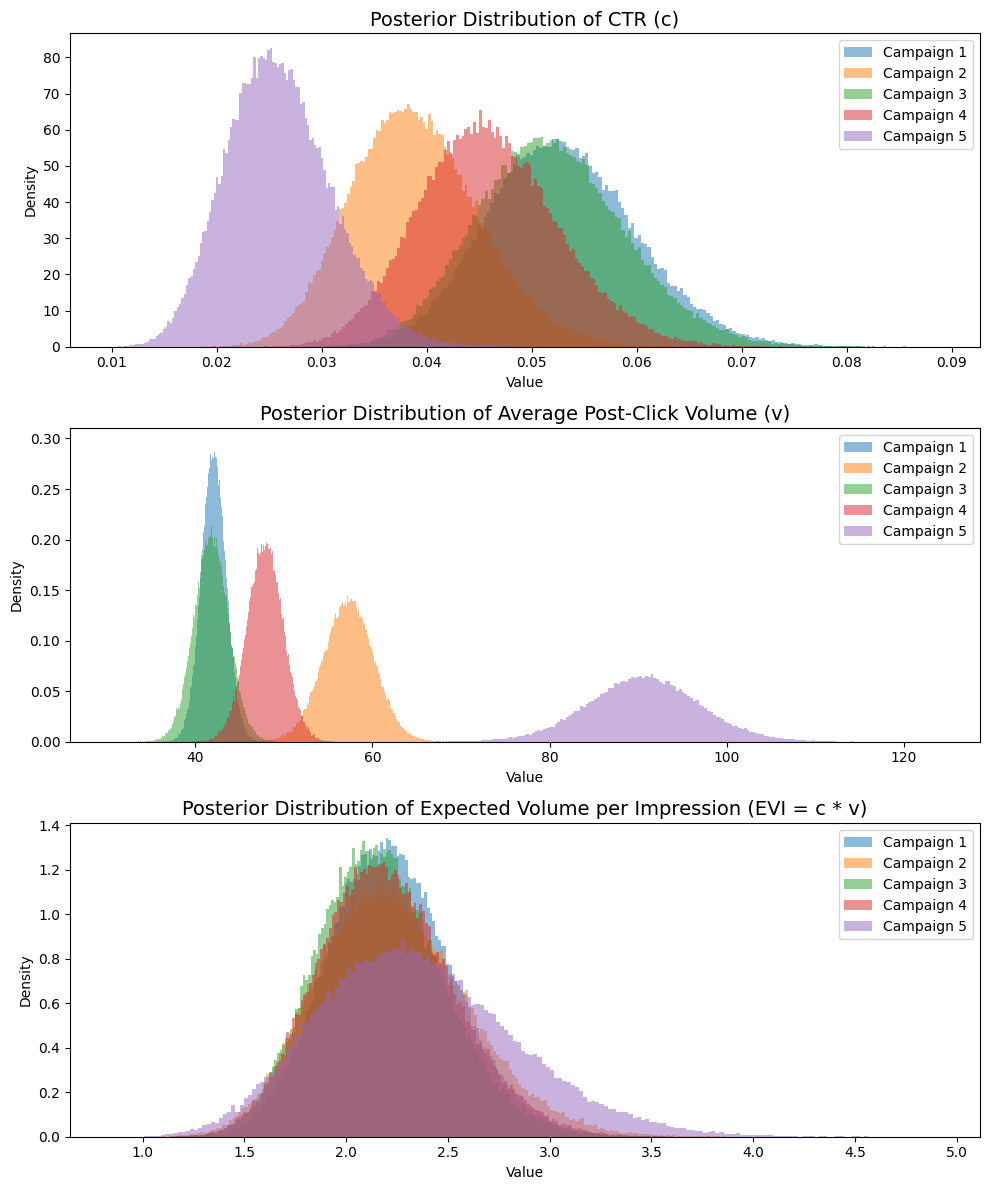

In [ ]:
# -----------------------------
# STEP 5. Posterior density plots
# -----------------------------

fig, axes = plt.subplots(3, 1, figsize=(10, 12))
titles = [
    'Posterior Distribution of CTR (c)',
    'Posterior Distribution of Average Post-Click Volume (v)',
    'Posterior Distribution of Expected Volume per Impression (EVI = c * v)'
]
draw_sets = [ctr_draws, v_draws, evi_draws]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for ax, draws, title in zip(axes, draw_sets, titles):
    for i in range(5):
        ax.hist(draws[:, i], bins=200, density=True, alpha=0.5,
                label=f'Campaign {i + 1}', color=colors[i])
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()

From the plots as well it is clear that Ad5 has the good distribution(EVI).

In [ ]:
# -----------------------------
# STEP 6. Compute Expected Regret
# -----------------------------

# Expected maximum EVI per draw
E_max_EVI = evi_draws.max(axis=1).mean()

# Expected regret = E[max EVI] - E[EVI of chosen campaign]
expected_regret = E_max_EVI - post_mean_evi

regret_df = pd.DataFrame({
    'campaign': [1, 2, 3, 4, 5],
    'post_mean_evi': post_mean_evi,
    'expected_regret': expected_regret
}).sort_values('expected_regret')

print("Expected Regret (lower is better):")
print(regret_df, "\n")

Expected Regret (lower is better):
   campaign  post_mean_evi  expected_regret
4         5       2.351365         0.338400
1         2       2.229889         0.459877
0         1       2.225919         0.463846
3         4       2.198945         0.490821
2         3       2.168535         0.521230 



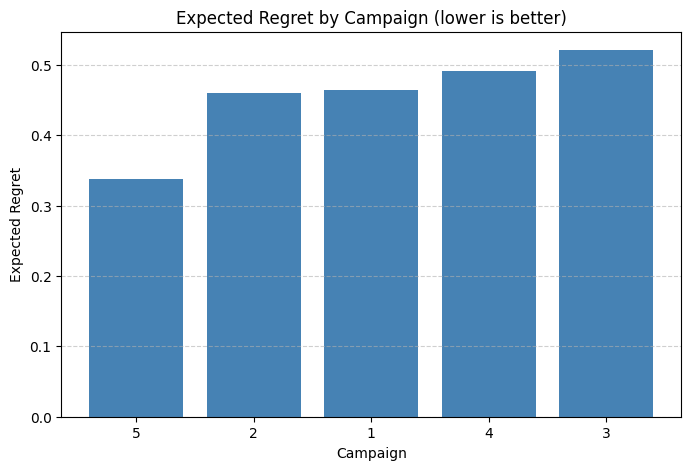

In [ ]:
# -----------------------------
# STEP 7. Regret visualization
# -----------------------------

plt.figure(figsize=(8, 5))
plt.bar(regret_df['campaign'].astype(str),
        regret_df['expected_regret'], color='steelblue')
plt.title('Expected Regret by Campaign (lower is better)')
plt.xlabel('Campaign')
plt.ylabel('Expected Regret')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# ---------------------------------------------------------------
# END OF SCRIPT
# ---------------------------------------------------------------


Based on the Regret value Ad campagin 5 has the lower value which is better for the organization.